# Visualise Predicted Tracks in Unknown Input

In [11]:
PATH_PREFIX = '../'
MODEL_SAVE_DIR = 'Model(Track)/'
MODEL_FILE = 'model.ckpt'
DATA_DIR = 'D0toPiKInAcceptanceSignal_Iteration1_Parsed/'
DATA_FILE_PATH = PATH_PREFIX + DATA_DIR + 'dataset_{:04d}.json'

FILE_NUMBER = 1
DATA_POINT = 100 # [1 - 100]

SCALE = 6

In [12]:
#@title Imports

import sys
sys.path.append(PATH_PREFIX)

from __future__ import absolute_import, division, print_function

from graphGenerator import to_graph_dict_with_edges

from graph_nets import utils_np, utils_tf
import modelTrack as model

import ujson, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [13]:
#@title Helper functions


def PlotModelPrediction(data,
                        true_positive,
                        true_negative,
                        false_positive,
                        title='Predicted Track by the Model',
                        scale=1,
                        show_layer=False,
                        save_loc=None):

    plt.close('all')
    fig = plt.figure(figsize=(4 * scale, 4 * scale), dpi=40 * scale)
    all_layers = [{'xx': [], 'yy': []} for _ in range(6)]
    for hits in data['tracks'].values():
        layers = [{'count': 0, 'x': 0, 'y': 0} for _ in range(6)]
        approx_track = {}
        for (layer, x, y) in hits:
            layers[layer]['count'] += 1
            layers[layer]['x'] += x
            layers[layer]['y'] += y
        for layer, pos in enumerate(layers):
            if pos['count']:
                approx_track[layer] = (1.0 * pos['x'] / pos['count'],
                                       1.0 * pos['y'] / pos['count'])
        for (layer, (x, y)) in approx_track.items():
            all_layers[layer]['xx'].append(x * scale)
            all_layers[layer]['yy'].append(y * scale)
            if show_layer:
                plt.annotate((layer + 1), (x * scale, y * scale))
    for layer, hits in enumerate(all_layers):
        plt.scatter(hits['xx'],
                    hits['yy'],
                    color='deepskyblue',
                    s=30,
                    alpha=1.0 * (layer + 1) / 6.0)
    for u, v in true_positive:
        plt.plot((u[0] * scale, v[0] * scale), (u[1] * scale, v[1] * scale),
                 linewidth=0.6,
                 color='green')
    for u, v in true_negative:
        plt.plot((u[0] * scale, v[0] * scale), (u[1] * scale, v[1] * scale),
                 ':',
                 linewidth=0.6,
                 color='green')
    for u, v in false_positive:
        plt.plot((u[0] * scale, v[0] * scale), (u[1] * scale, v[1] * scale),
                 linewidth=0.6,
                 color='red')
    plt.xlim(0, 1024 * scale)
    plt.ylim(0, 1024 * scale)
    plt.title(title)
    if save_loc:
        plt.savefig(save_loc)
        plt.close(fig)


def generate_dict_graphs(raw_data, offset, batch_size):
    input_graphs = []
    for i in range(offset, offset + batch_size):
        input_graph_dict, _, _, _, _ = to_graph_dict_with_edges(raw_data[i])
        input_graphs.append(input_graph_dict)
    return input_graphs


def create_placeholders(raw_data, offset, batch_size):
    input_graphs = generate_dict_graphs(raw_data, offset, batch_size)
    input_ph = utils_tf.placeholders_from_data_dicts(input_graphs)
    return input_ph


def create_feed_dict(raw_data, offset, batch_size, input_ph):
    inputs = generate_dict_graphs(raw_data, offset, batch_size)
    input_graphs = utils_np.data_dicts_to_graphs_tuple(inputs)
    feed_dict = {input_ph: input_graphs}
    return feed_dict


def classify_predicted_edges(data, prediction):
    true_positive, true_negative, false_positive = set([]), set([]), set([])
    for hits in data['tracks'].values():
        layers = [{'count': 0, 'x': 0, 'y': 0} for _ in range(6)]
        approx_track = {}
        for (layer, x, y) in hits:
            layers[layer]['count'] += 1
            layers[layer]['x'] += x
            layers[layer]['y'] += y
        for layer, pos in enumerate(layers):
            if pos['count']:
                approx_track[layer] = (1.0 * pos['x'] / pos['count'],
                                       1.0 * pos['y'] / pos['count'])
        prev_node, edges = None, {}
        for i, layer in enumerate(sorted(approx_track.keys())):
            edges[approx_track[layer]] = None
            if i != 0:
                edges[prev_node] = approx_track[layer]
            prev_node = approx_track[layer]
        for u, v in edges.items():
            if v is not None:
                if u in prediction or v in prediction:
                    if (u in prediction and v in prediction[u]) or (
                            v in prediction and u in prediction[v]):
                        true_positive.add((u, v))
                    else:
                        true_negative.add((u, v))
                    if u in prediction:
                        prediction[u].discard(v)
                    if v in prediction:
                        prediction[v].discard(u)
                else:
                    true_negative.add((u, v))
    for u in prediction:
        for v in prediction[u]:
            if (v, u) not in false_positive:
                false_positive.add((u, v))

    return true_positive, true_negative, false_positive

In [14]:
#@title Restore Model

tf.reset_default_graph()

test_raw_data = ujson.loads(open(DATA_FILE_PATH.format(FILE_NUMBER), 'r').read())

input_ph = create_placeholders(test_raw_data, DATA_POINT - 1, 1)

num_processing_steps = 10

model = model.EncodeProcessDecode(edge_output_size=2)

test_outputs = model(input_ph, num_processing_steps)

input_ph = utils_tf.make_runnable_in_session(input_ph)

saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, PATH_PREFIX + MODEL_SAVE_DIR + MODEL_FILE)
print("Model restored")

INFO:tensorflow:Restoring parameters from ../Model(Track)/model.ckpt
Model restored


testing file #0001 ... finished in 1.34s


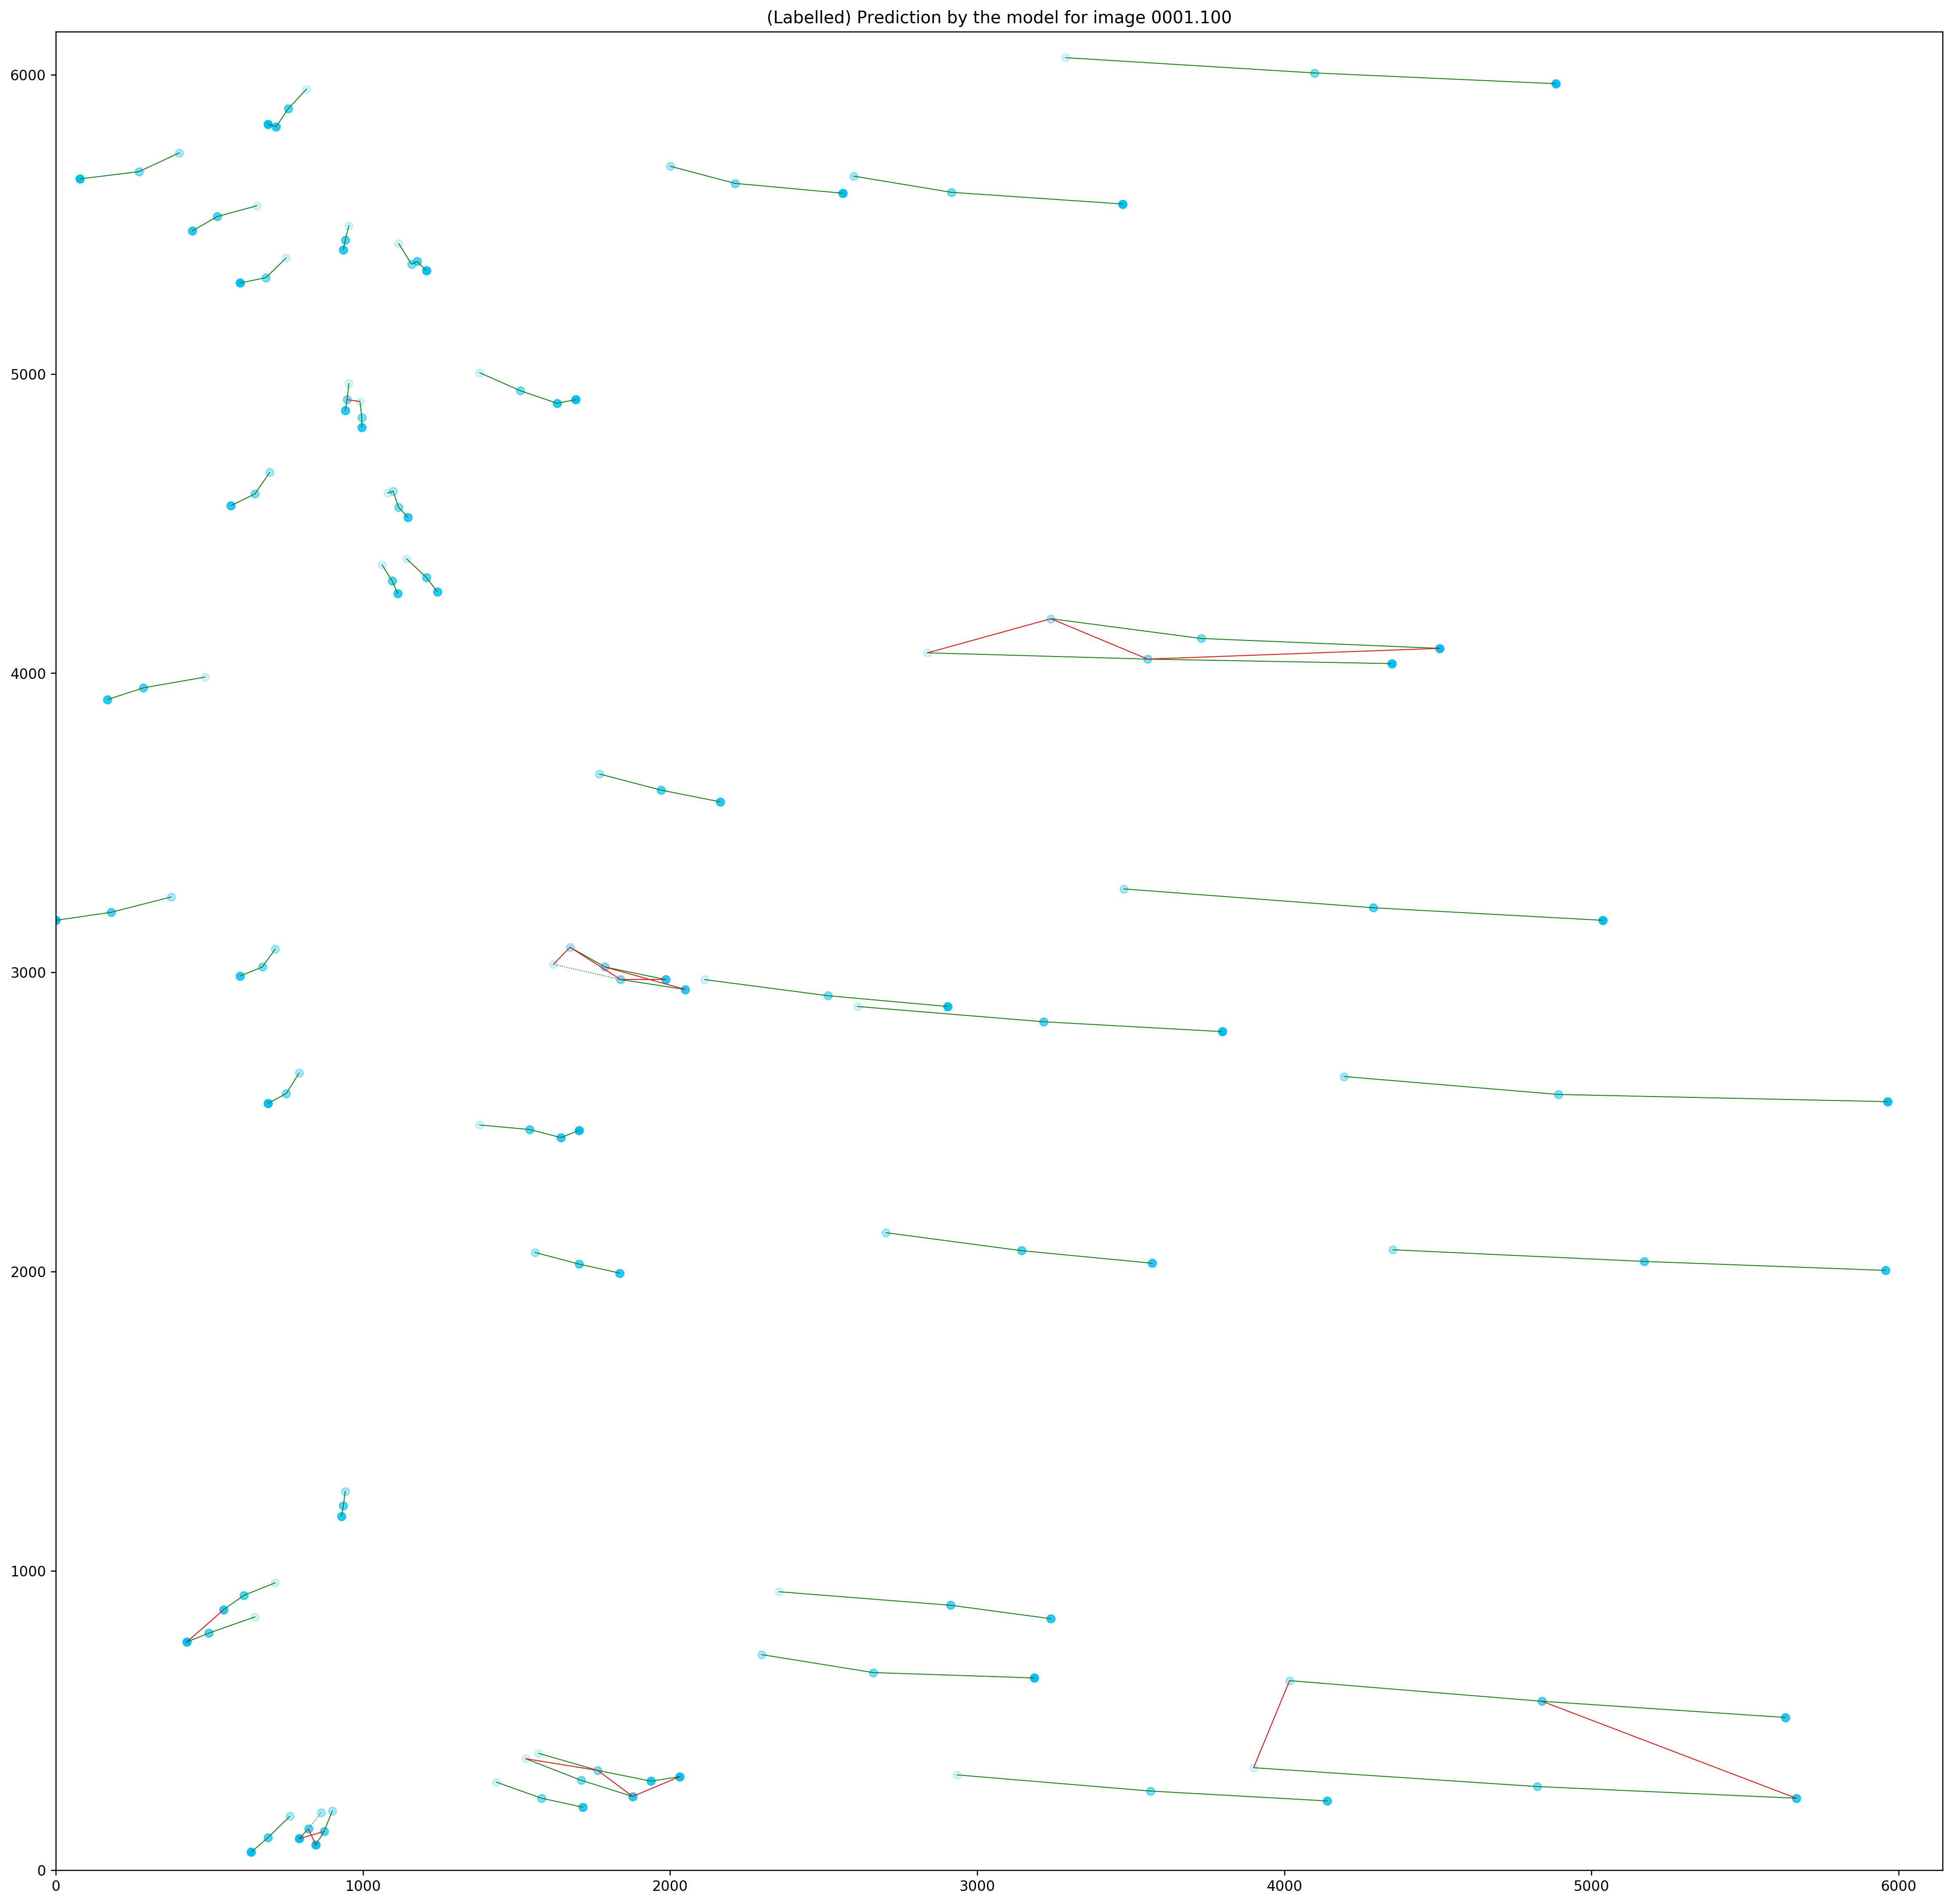

In [15]:
#@title Test Unknown Input

start_time = time.time()
f = open(DATA_FILE_PATH.format(FILE_NUMBER), 'r')
test_raw_data = ujson.loads(f.read())
f.close()

try:
    print('testing file #{:04d} ...'.format(FILE_NUMBER), end=' ')
    feed_dict = create_feed_dict(test_raw_data, DATA_POINT - 1, 1, input_ph)
    test_values = sess.run({
        'inputs': input_ph,
        'outputs': test_outputs
    },
                           feed_dict=feed_dict)
except Exception as e:
    print('skipped because of exception: {}'.format(e))
else:
    elapsed_time = time.time() - start_time
    print('finished in {:.2f}s'.format(elapsed_time))

    input = test_values['inputs']
    output = test_values['outputs'][-1]

    idds = utils_np.graphs_tuple_to_data_dicts(input)
    odds = utils_np.graphs_tuple_to_data_dicts(output)

    dimension = 1024
    raw_data = test_raw_data[DATA_POINT - 1]
    id = idds[0]
    od = odds[0]
    track_edges = np.argmax(od['edges'], axis=-1).astype(bool)
    predicted_track_edges = {}
    for j, edge in enumerate(id['edges']):
        if track_edges[j]:
            ux, uy, vx, vy = tuple((edge[1:5] * dimension).astype(float))
            if (ux, uy) not in predicted_track_edges:
                predicted_track_edges[(ux, uy)] = set([])
            if (vx, vy) not in predicted_track_edges:
                predicted_track_edges[(vx, vy)] = set([])
            predicted_track_edges[(ux, uy)].add((vx, vy))
            predicted_track_edges[(vx, vy)].add((ux, uy))

    true_positive, true_negative, false_positive = classify_predicted_edges(
        raw_data, predicted_track_edges)
    predicted_track_edges = true_positive.union(false_positive)

    # set of edges predicted to be track-edges by the model
    # print(predicted_track_edges)

    PlotModelPrediction(
        raw_data,
        true_positive,
        true_negative,
        false_positive,
        scale=SCALE,
        title='(Labelled) Prediction by the model for image {:04d}.{:03d}'.
        format(FILE_NUMBER, DATA_POINT))

sess.close()